In [1]:
import os
os.chdir('../')
os.getcwd()

'/work'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from tqdm.notebook import tqdm

# 実験コードの作成

In [4]:
from process.preprocess.get_dataset import get_dataset
from process.preprocess.get_set_options import get_options
from process.preprocess.turn_params import turn_params
from process.mainprocess.split_data import split_data
from process.mainprocess.run_model import run_model

In [5]:
class Args():
    def __init__(self, dataset, source, metrics, tune=False):
        self.dataset = dataset
        self.source = source
        self.metrics = metrics
        self.baseline = None
        self.tune = tune
        
CONFIG_DIR_UCI = './configs/experiments_uci.yml'
CONFIG_DIR_WEKA = './configs/experiments_weka.yml'

args_auto_mobile = Args("auto_mobile", "weka", "RMSE")
args_autoMPG = Args("autoMPG", "weka", "RMSE")
args_concrete = Args("concrete", "weka", "RMSE")
args_housing = Args("housing", "weka", "RMSE")
args_mushroom = Args("mushroom", "uci", "error rate", tune=False)

In [11]:
tuned_params = {
    "auto_mobile": {"learning_rate": 0.10834198579491956, "max_depth": 13},
    "autoMPG": {"learning_rate": 0.4591715202801833, "max_depth": 28},
    "concrete": {"learning_rate": 0.40133364966682505, "max_depth": 29},
    "housing": {"learning_rate": 0.08981989739549917, "max_depth": 24},
    "mushroom": {"learning_rate":0.1 ,"max_depth":6}
}

def _set_params(options):
    dataset = options["datasets"]["dataset_name"]
    params = tuned_params[dataset]
    options["model_params"]["DartForDomainAdaptation"]["learning_rate"] = \
        params["learning_rate"]
    options["model_params"]["DartForDomainAdaptation"]["max_depth"] = \
        params["max_depth"]
    options["model_params"]["DartForDomainAdaptation"]["is_drop_dynamically"] = False
    options["model_params"]["DartForDomainAdaptation"]["drop_mode"] = "latest"
    
    return options
        

def preprocesses(args):
    options = get_options(args)
    df = get_dataset(options["datasets"])
    if args.tune:
        options = turn_params(options, None, df, is_plot=False)
    else:
        options = _set_params(options)
    
    return options, df

In [12]:
DROP_RATE = range(0, 10, 1)
DROP_RATE_PER = 10.0
ADDITIONAL_TREE = range(0, 100, 10)

def _experiment_main(options, df, target_domain, exp_round):

    X_train, y_train, X_train_target, y_train_target, X_test, y_test, domain_col = \
        split_data(options, df, target_domain, exp_round)
    
    # 提案手法のみ
    model_name = "DART for DA"

    result = {}
    # drop_rateとn_estimators_addをずらしていく
    for drop_rate_ in DROP_RATE:
        drop_rate = drop_rate_ / DROP_RATE_PER
        options["model_params"]["DartForDomainAdaptation"]["drop_rate"] = drop_rate
        for additional_tree in ADDITIONAL_TREE:
            options["model_params"]["DartForDomainAdaptation"]["n_estimators_add"] = additional_tree
            result[f"DropRate:{drop_rate} n_add:{additional_tree}"] = run_model(
                X_train, y_train, X_train_target, y_train_target, X_test, y_test, 
                domain_col, options, model_name, target_domain
            )

    return result


def mainprocess(options, df):

    # 各パラメータを取り出す
    cols = []
    for drop_rate_ in DROP_RATE:
        drop_rate = drop_rate_ / DROP_RATE_PER
        for additional_tree in ADDITIONAL_TREE:
            cols.append(f"DropRate:{drop_rate} n_add:{additional_tree}")
    cols += ["target_domain"]
    domains = df[options['datasets']['split_feature']].unique()
    n_domains = len(domains)
    n_experiments = options['experiments']['n_experiments']

    # tqdm設定
    bar = tqdm(total=n_domains*n_experiments)
    bar.set_description('Experiments progress')

    # 実験
    results = pd.DataFrame(columns=cols, index=range(n_domains*n_experiments), dtype=float)
    for domain_num, target_domain in enumerate(domains):
        for exp_round in range(n_experiments):
            idx = domain_num*n_experiments + exp_round
            # 実験結果の取得
            result = _experiment_main(options, df, target_domain, exp_round)
            # 手法ごとの実験結果を代入
            for col, val in result.items():
                results.loc[idx, col] = val
            results.loc[idx,cols[-1]] = target_domain
            bar.update(1)

    return results

In [13]:
def _get_summary(results):
    summary = results.set_index("target_domain").stack().reset_index()
    summary["drop_rate"]=summary["level_1"].apply(lambda x: float(x.split(" ")[0].split(":")[-1]))
    summary["n_add"]=summary["level_1"].apply(lambda x: float(x.split(" ")[1].split(":")[-1]))
    summary.rename(columns={0:"rmse"}, inplace=True)
    
    return summary[["target_domain", "drop_rate", "n_add", "rmse"]]


def _get_violinplot(df, x_label, title):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1, 1, 1)
    sns.violinplot(x=x_label, y='rmse', hue="target_domain", data=df, ax=ax)
    ax.set_title(title)
    
    return fig


def postprocesses(options, results):
    summary = _get_summary(results)
    title = options["datasets"]["dataset_name"]
    fig_drop_rate = _get_violinplot(summary, "drop_rate", title)
    fig_n_add = _get_violinplot(summary, "n_add", title)
    
    return summary, fig_drop_rate, fig_n_add

In [14]:
def run(args):
    options, df = preprocesses(args)
    results= mainprocess(options, df)
    summary, fig_drop_rate, fig_n_add = postprocesses(options, results)
    
    return results, summary, fig_drop_rate, fig_n_add

# run

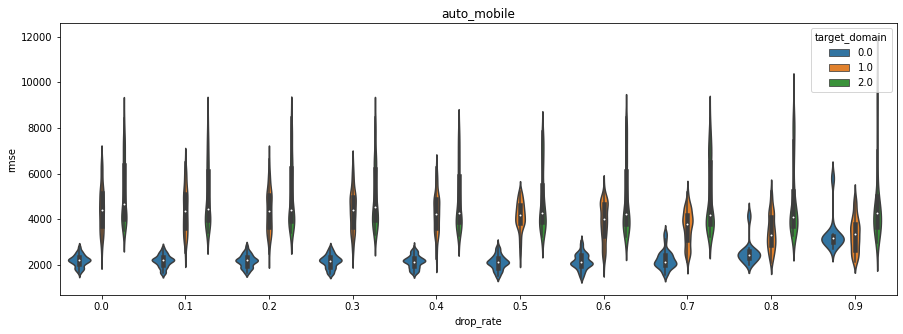

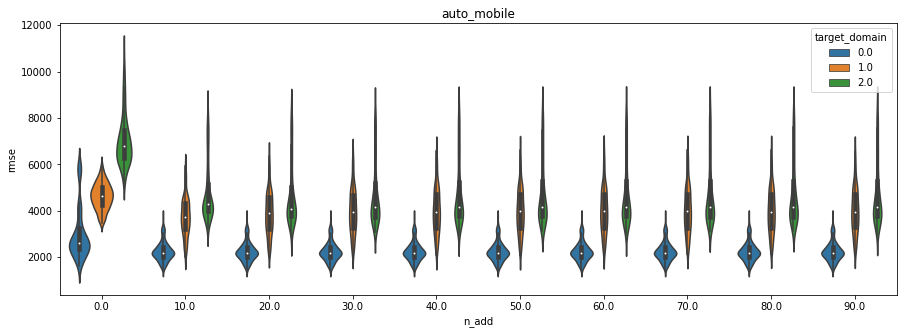

In [15]:
results_auto_mobile, summary_auto_mobile, \
fig_drop_rate_auto_mobile, fig_n_add_auto_mobile = run(args_auto_mobile)

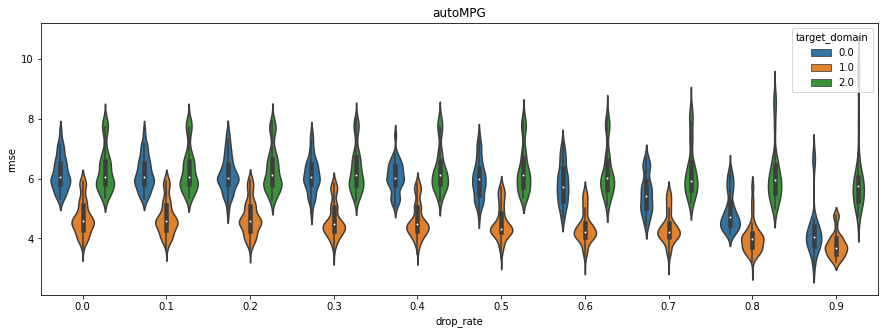

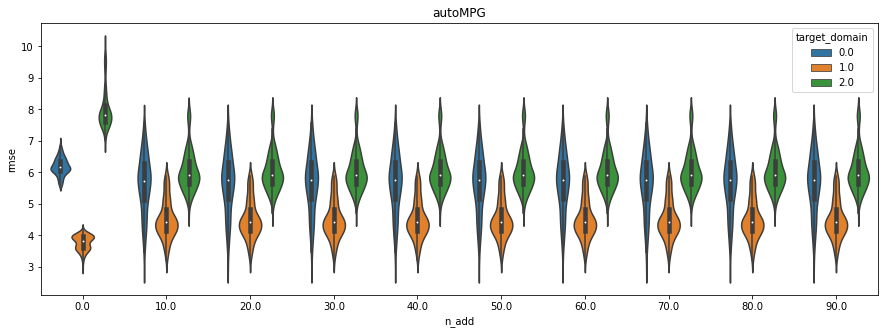

In [16]:
results_autoMPG, summary_autoMPG, \
fig_drop_rate_autoMPG, fig_n_add_autoMPG = run(args_autoMPG)

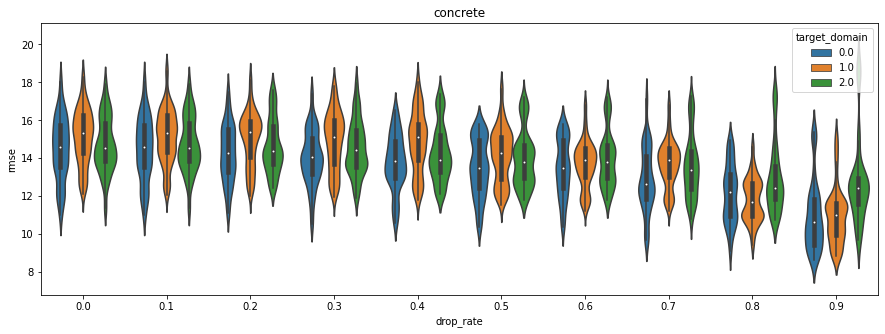

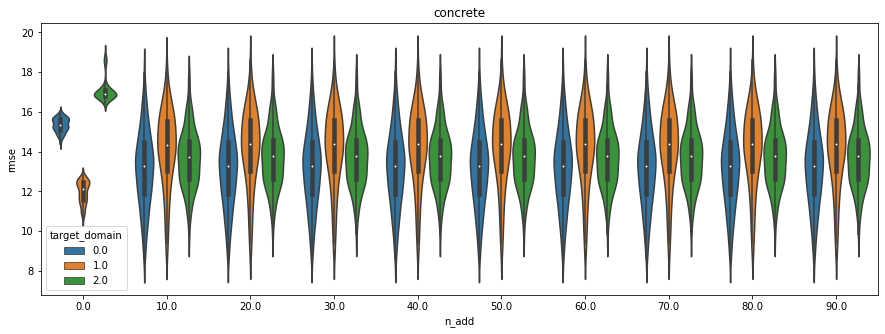

In [17]:
results_concrete, summary_concrete, \
fig_drop_rate_concrete, fig_n_add_concrete = run(args_concrete)

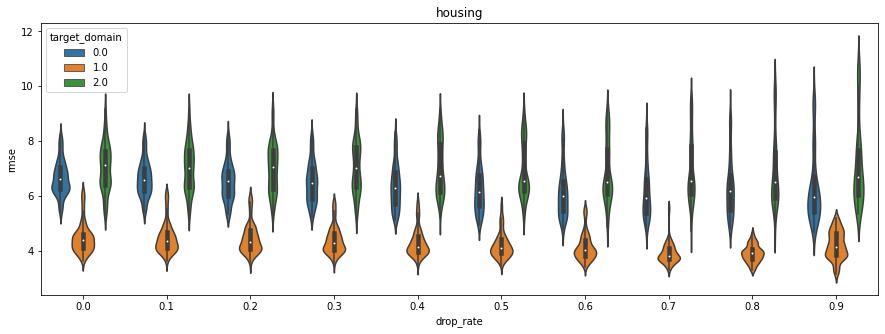

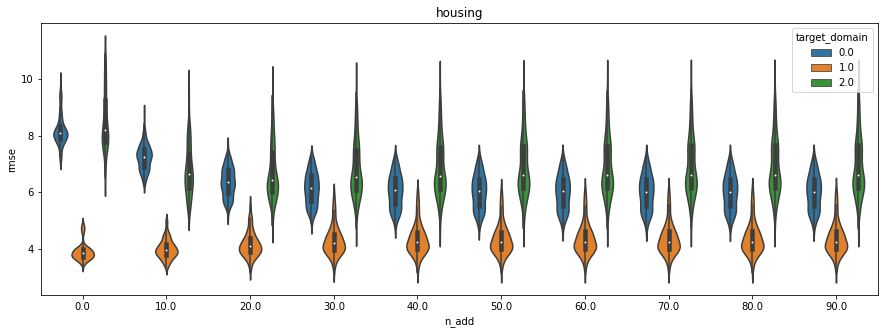

In [18]:
results_housing, summary_housing, \
fig_drop_rate_housing, fig_n_add_housing = run(args_housing)

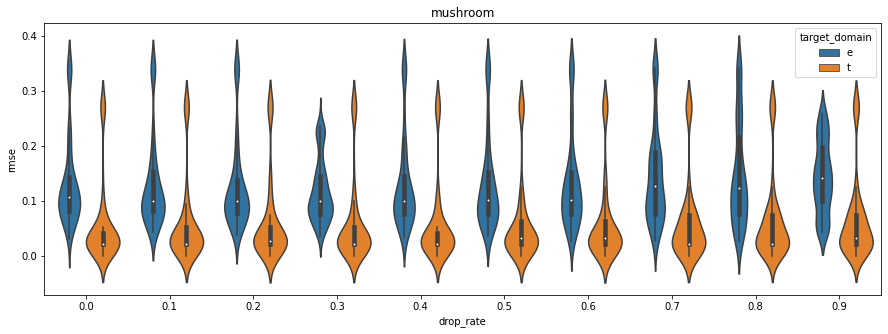

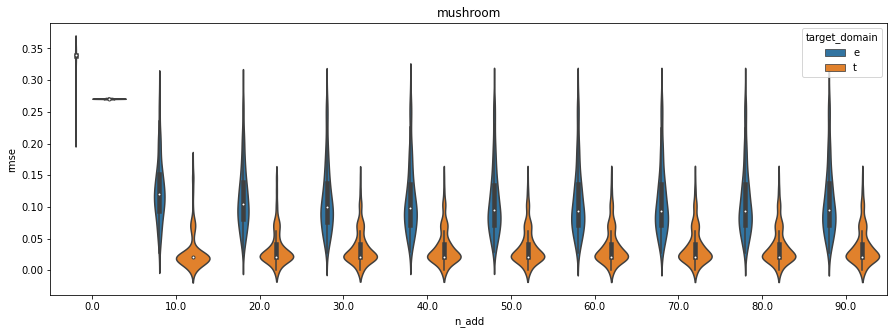

In [19]:
results_mushroom, summary_mushroom, \
fig_drop_rate_mushroom, fig_n_add_mushroom = run(args_mushroom)

In [20]:
summary_mushroom

,target_domain,drop_rate,n_add,rmse
0,e,0.0,0.0,0.340017
1,e,0.0,10.0,0.118018
2,e,0.0,20.0,0.120309
3,e,0.0,30.0,0.092810
4,e,0.0,40.0,0.092810
...,...,...,...,...
5995,t,0.9,50.0,0.062841
5996,t,0.9,60.0,0.062841
5997,t,0.9,70.0,0.062841
5998,t,0.9,80.0,0.062841


# まとめ

## 実験ごとでの最適パラメータ比較

### drop_rateとn_addの影響をdataset＆domainごとに可視化

(0.0, 1.0, 0.0, 1.0)

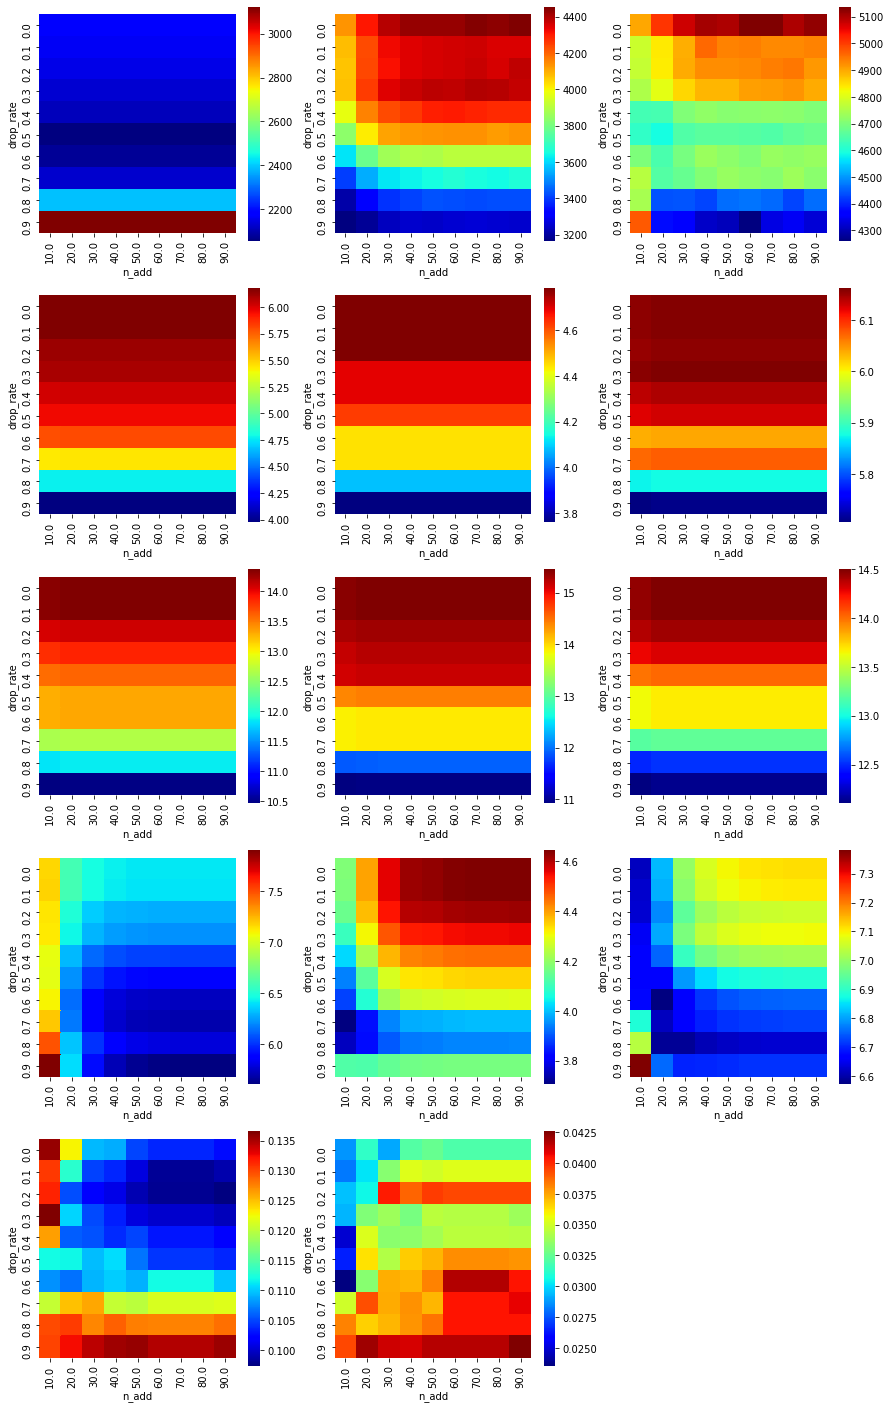

In [21]:
fig, ax = plt.subplots(5,3, figsize=(15,25))
for idx, summary in enumerate([summary_auto_mobile,summary_autoMPG,summary_concrete,summary_housing,summary_mushroom]):
    for col, (domain, summary_one) in enumerate(summary.groupby("target_domain")):
        ex = summary_one.groupby(["drop_rate","n_add"])["rmse"].mean()
        # n_add=0は精度悪すぎるのでグラフから除く
        ex1 = ex.reset_index().pivot("drop_rate","n_add","rmse").iloc[:,1:]
        sns.heatmap(ex1, cmap="jet", ax=ax[idx,col], square=True)
ax[-1,-1].axis('off')

データセットやターゲットドメインによって結果が異なり、ハイパラの調整が難しい

### drop_rateのみ

In [24]:
summary_dict = {
    "auto_mobile": summary_auto_mobile,
    "autoMPG": summary_autoMPG,
    "concrete": summary_concrete,
    "housing": summary_housing,
    "mushroom": summary_mushroom
}

In [25]:
from sklearn.preprocessing import MinMaxScaler

In [26]:
df_line = pd.DataFrame(columns=["dataset_domain","drop_rate","metrics"])
for dataset, summary in summary_dict.items():
    for domain, summary_one in summary.groupby("target_domain"):
        ex = summary_one.groupby("drop_rate")["rmse"].mean()
        scaler = MinMaxScaler()
        df_one = pd.DataFrame()
        df_one["metrics (MinMaxScaled)"] = scaler.fit_transform(ex.values.reshape(-1,1)).reshape(-1)
        df_one["dataset_domain"]=  f"{dataset}_{domain}"
        df_one["drop_rate"] = ex.index
        df_line = pd.concat([df_line, df_one], sort=False)

<AxesSubplot:xlabel='drop_rate', ylabel='metrics (MinMaxScaled)'>

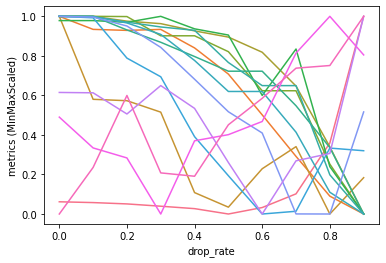

In [27]:
sns.lineplot(df_line["drop_rate"],df_line["metrics (MinMaxScaled)"],df_line["dataset_domain"], legend=False)

データセット・ターゲットドメインによってmetricsが最小になるdrop_rateは様々